# Praktikum 3: Softmax, Regularisierung, Momentum und Batchsize
## 4. Eigener Datensatz
Suchen Sie sich eine verfügbare PyTorch MLP-Implementierung für einen Datensatz heraus, der Sie besonders interessiert. Reproduzieren Sie die Ergebnisse lokal, auf colab oder RosettaHub. Ist die Implementierung vergleichbar mit der hier gegebenen IMDB Implementierung? Wo unterscheidet sich diese und ggf. warum? Wie verändern Sich die Ergebnisse, wenn Sie bestimmte Hyperparameter verändern?

Quelle: https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md


In [42]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

import numpy as np

Unterschied zu IMDB Implementierung:
- hier feste Neuronenanzahl je Layer, andere werden erst bei Initialisierung festgelegt
- vorher flatten() ausgeführt, bei uns wird x_train vorher in torch umgewandelt
- ReLU statt sigmoid verwendet
- keine Aktivierungsfunktion im letzten Layer

In [2]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

Unterschied zu IMDB Implementierung:
- Funktion zur erstellung der batches selbst definiert
- Batchsize 100 statt 10

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [3]:
# Prepare CIFAR-10 dataset
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

Files already downloaded and verified


Unterschied zu IMDB Implementierung:
- Adam statt SGD optimizer
- beide verwenden CrossEnropyLoss

In [4]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

Unterschied zu IMDB Implementierung:
- kaum Unterschied zur IMDB Implementierung
- Epochenanzahl festgelegt und nicht variabel

In [5]:
loss_list = [] 
# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        loss_list.append(loss.item())

        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0

    # Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 2.220
Loss after mini-batch  1000: 2.043
Loss after mini-batch  1500: 1.965
Loss after mini-batch  2000: 1.956
Loss after mini-batch  2500: 1.934
Loss after mini-batch  3000: 1.900
Loss after mini-batch  3500: 1.890
Loss after mini-batch  4000: 1.862
Loss after mini-batch  4500: 1.869
Loss after mini-batch  5000: 1.874
Starting epoch 2
Loss after mini-batch   500: 1.833
Loss after mini-batch  1000: 1.816
Loss after mini-batch  1500: 1.831
Loss after mini-batch  2000: 1.839
Loss after mini-batch  2500: 1.819
Loss after mini-batch  3000: 1.824
Loss after mini-batch  3500: 1.792
Loss after mini-batch  4000: 1.775
Loss after mini-batch  4500: 1.778
Loss after mini-batch  5000: 1.773
Starting epoch 3
Loss after mini-batch   500: 1.766
Loss after mini-batch  1000: 1.752
Loss after mini-batch  1500: 1.755
Loss after mini-batch  2000: 1.741
Loss after mini-batch  2500: 1.742
Loss after mini-batch  3000: 1.742
Loss after mini-batch  3500: 1.719
Loss

In [38]:
loss_list = [] 
loss_dict = dict()
accuracy_list = []
correct = []

# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        loss_list.append(loss.item())

        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            if epoch == 0:
                loss_dict[i] = [current_loss/500]
            else:
                loss_dict[i].append(current_loss/500)
            current_loss = 0.0

        # Es gibt keine Testdaten
        # Anzahl korrekter Daten ermitteln
        # correct.append(outputs == targets)

    # accuracy_list[epoch] = correct.mean()
    # correct = []

    # Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 1.468
Loss after mini-batch  1000: 1.477
Loss after mini-batch  1500: 1.476
Loss after mini-batch  2000: 1.456
Loss after mini-batch  2500: 1.481
Loss after mini-batch  3000: 1.486
Loss after mini-batch  3500: 1.465
Loss after mini-batch  4000: 1.492
Loss after mini-batch  4500: 1.464
Loss after mini-batch  5000: 1.457
Starting epoch 2
Loss after mini-batch   500: 1.469
Loss after mini-batch  1000: 1.475
Loss after mini-batch  1500: 1.458
Loss after mini-batch  2000: 1.451
Loss after mini-batch  2500: 1.461
Loss after mini-batch  3000: 1.480
Loss after mini-batch  3500: 1.445
Loss after mini-batch  4000: 1.447
Loss after mini-batch  4500: 1.461
Loss after mini-batch  5000: 1.462
Starting epoch 3
Loss after mini-batch   500: 1.459
Loss after mini-batch  1000: 1.453
Loss after mini-batch  1500: 1.461
Loss after mini-batch  2000: 1.443
Loss after mini-batch  2500: 1.454
Loss after mini-batch  3000: 1.429
Loss after mini-batch  3500: 1.474
Loss

wieso 10 statt 1 Wert wie in target?

In [65]:
outputs

tensor([[-0.8609,  1.7431, -1.0978, -0.9496, -2.9801, -0.2887, -4.4973, -1.7122,
         -2.0206,  0.7432],
        [-3.0747, -4.9194,  2.8974, -0.3734,  3.0910, -0.0913,  2.8786, -3.0414,
         -7.6062, -4.4899],
        [-0.5801, -3.7258,  0.0334,  0.0324,  0.2386, -0.0231, -1.1166, -0.9185,
         -0.9884, -2.1000],
        [-1.2216, -1.3631, -1.8449, -1.3011, -0.6526, -1.6758, -1.8152,  0.4252,
         -1.3939,  1.0132],
        [ 3.9904,  0.6368, -0.6789, -2.3503, -0.5014, -3.0235, -6.0184, -1.5570,
          3.5904, -2.2641],
        [ 2.0568, -0.7545,  0.2497, -1.3853, -0.2999, -1.9899, -2.8254, -3.3700,
          1.8902, -2.1705],
        [ 0.6668, -2.0779, -1.0808, -1.0320,  0.6356, -2.0743, -3.3421, -0.1053,
         -0.1474, -3.7119],
        [-0.4182, -2.0291, -0.8717, -0.6907, -1.7025, -0.9246, -2.4901,  1.6799,
         -6.7095, -1.5203],
        [-2.6290, -3.0984, -1.7737, -1.2159, -0.0174, -0.9231, -1.5402,  3.7637,
         -4.9489, -1.3665],
        [-0.0432, -

In [66]:
targets

tensor([2, 2, 5, 7, 0, 0, 8, 7, 7, 7])

Text(0.5, 1.0, 'Durchschnittlicher Loss aus 500 Trainingsschritten \nje Epoche')

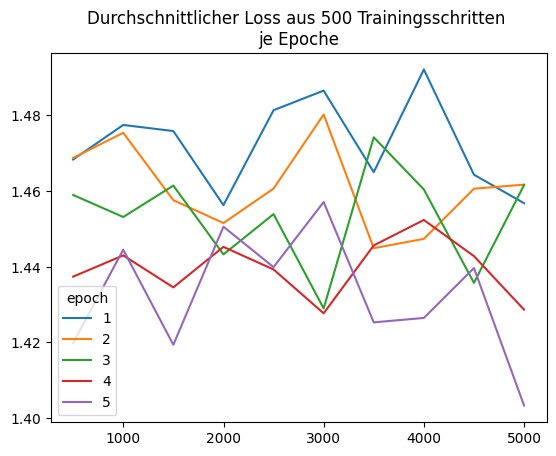

In [58]:
#plot changing loss for each epoch
labels = range(1, len(loss_dict[499])+1)
plt.plot(loss_dict.keys(), loss_dict.values(),label = labels)
plt.legend(title = 'epoch')
plt.title('Durchschnittlicher Loss aus 500 Trainingsschritten \nje Epoche')

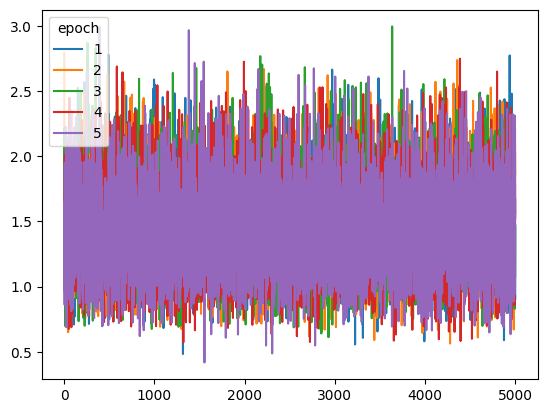

In [56]:
# Damit Grafik mit jeder Epochenanzahl funktioniert
epoch_count = len(loss_list) // 5000  # Ganzzahldivision
loss_list_chunked = np.array_split(loss_list, epoch_count)


for i in range(epoch_count):
    plt.plot(range(1,5001), loss_list_chunked[i],label = i+1)
plt.legend(title = 'epoch')


In [51]:
len(loss_list_chunked)

5